<a href="https://colab.research.google.com/github/ricardogr07/trabajo-final-series-tiempo/blob/main/src/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Correr para descargar librerias
!pip install pandas matplotlib statsmodels scikit-learn numpy


[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cargar dataset del precio del oro
try:
    oro = pd.read_csv("../dataset/oro.csv", parse_dates=["Date"], index_col="Date")
except FileNotFoundError:
    print("Archivo no encontrado. Descargando el dataset...")

    # Crear el directorio si no existe
    import os
    os.makedirs("../dataset", exist_ok=True)

    # URL del dataset mensual del precio del oro (USD/oz)
    url = "https://datahub.io/core/gold-prices/r/monthly.csv"

    # Leer y procesar
    oro = pd.read_csv(url, parse_dates=["Date"], index_col="Date")

    # Guardar en ../dataset/
    oro.to_csv("../dataset/oro.csv")
finally:
    print("Cargar información desde 2000.")
    oro = oro[oro.index >= "2000-01-01"]
    oro.rename(columns={"Price": "Gold_Price"}, inplace=True)
    print(oro.head())

Cargar información desde 2000.
            Gold_Price
Date                  
2000-01-01      284.32
2000-02-01      299.86
2000-03-01      286.39
2000-04-01      279.69
2000-05-01      275.19


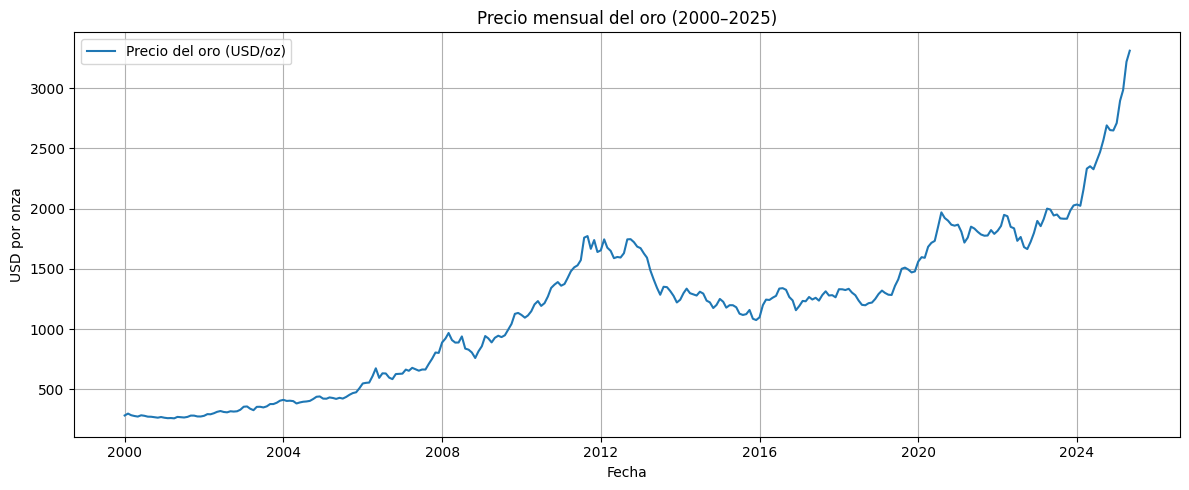

In [ ]:
# Graficar la serie de precios
plt.figure(figsize=(12, 5))
plt.plot(oro.index, oro["Gold_Price"], label="Precio del oro (USD/oz)")
plt.title("Precio mensual del oro (2000–2025)")
plt.xlabel("Fecha")
plt.ylabel("USD por onza")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación de la transformación logarítmica sobre el precio del oro

### Argumentos a favor de aplicar `log(Gold_Price)`

1. **Estabilización de la varianza**:  
   La gráfica del precio del oro en escala natural muestra una clara tendencia creciente, acompañada de un aumento en la amplitud de las fluctuaciones. Este patrón sugiere la presencia de heterocedasticidad, es decir, una varianza que crece con el nivel del precio. Al aplicar el logaritmo natural, se estabiliza la varianza relativa, lo cual es deseable para cumplir con los supuestos de modelos lineales como ARIMA o SARIMA.

2. **Interpretación económica**:  
   Modelar el logaritmo del precio permite interpretar las diferencias como tasas de crecimiento aproximadas. Esto es particularmente útil en series financieras y económicas donde se priorizan los cambios porcentuales más que los absolutos.

3. **Linealización de relaciones**:  
   En muchos casos, una serie con crecimiento exponencial o multiplicativo puede ser aproximada como aditiva después de una transformación logarítmica, facilitando el modelado con técnicas lineales.

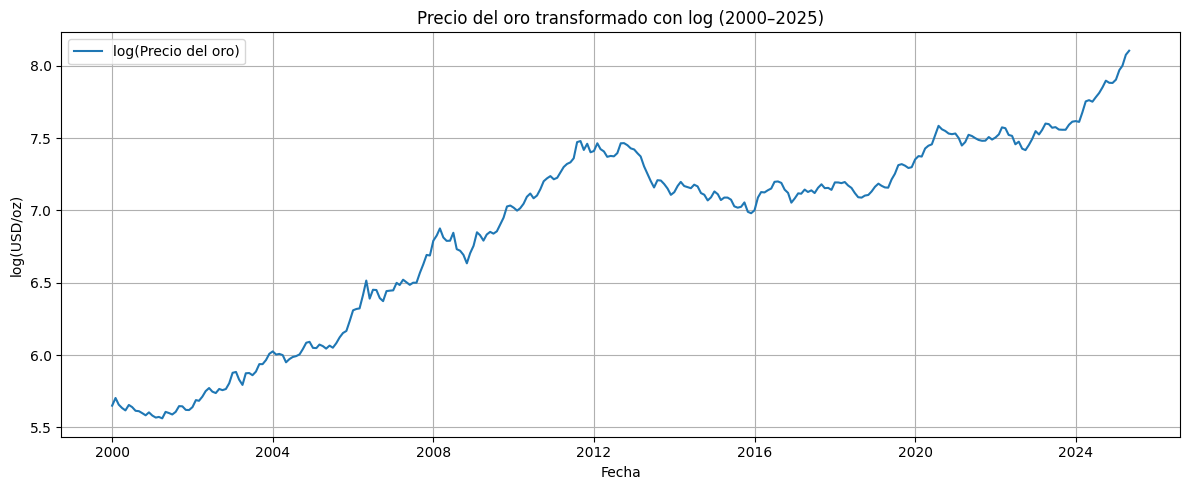

ADF Statistic: -0.3844943429455865
p-value: 0.9126556544790236
La serie NO es estacionaria.


In [ ]:
# Transformación logarítmica
oro["log_Gold_Price"] = np.log(oro["Gold_Price"])

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(oro.index, oro["log_Gold_Price"], label="log(Precio del oro)")
plt.title("Precio del oro transformado con log (2000–2025)")
plt.xlabel("Fecha")
plt.ylabel("log(USD/oz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Prueba de estacionariedad ADF
resultado_adf = adfuller(oro["log_Gold_Price"].dropna())
print(f"ADF Statistic: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")
if resultado_adf[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie NO es estacionaria.")



Esto indica que la serie logarítmica no es estacionaria, ya que el p-value es muy superior al umbral comúnmente aceptado de 0.05.

### Conclusión

Aplicar la transformación logarítmica sobre el precio del oro es una decisión adecuada y justificada tanto desde una perspectiva estadística como interpretativa. Sin embargo, la serie resultante aún presenta no estacionariedad, por lo que se recomienda aplicar una diferenciación sobre `log(Gold_Price)` antes de proceder con el análisis de autocorrelaciones y el modelado.


## Análisis de autocorrelación y autocorrelación parcial sobre log-precios diferenciados

### Transformación adicional: primera diferencia de `log(Gold_Price)`

Dado que la serie `log(Gold_Price)` no es estacionaria según la prueba de Dickey-Fuller, se procede a aplicar una primera diferencia. Esto equivale a modelar los retornos logarítmicos, que en términos económicos representan las tasas de crecimiento relativas mensuales del precio del oro.

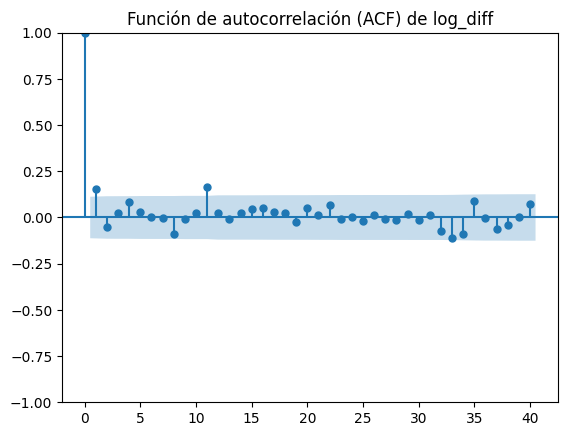

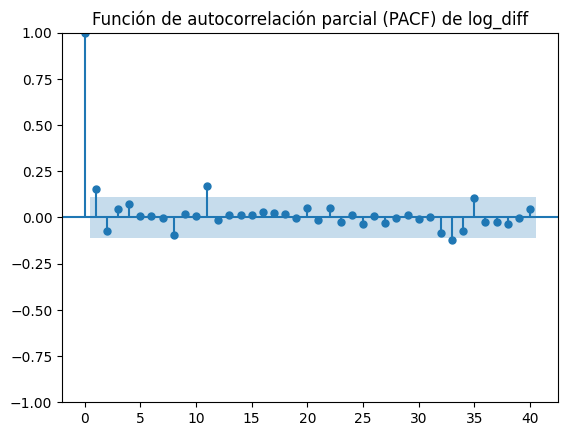

In [ ]:
# Calcular diferencia
oro["log_diff"] = oro["log_Gold_Price"].diff()
log_diff = oro["log_diff"].dropna()

# Graficar ACF
plot_acf(log_diff, lags=40)
plt.title("Función de autocorrelación (ACF) de log_diff")
plt.show()

# Graficar PACF
plot_pacf(log_diff, lags=40, method='ywm')
plt.title("Función de autocorrelación parcial (PACF) de log_diff")
plt.show()


## Interpretación de ACF y PACF sobre los log-retornos del precio del oro

Tras aplicar la primera diferencia a `log(Gold_Price)`, se analizaron las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) sobre la serie `log_diff`. Los gráficos resultantes se interpretan a continuación.

### ACF (Función de autocorrelación)

- Se observa un pico significativo en el lag 1, y posteriormente todas las autocorrelaciones caen dentro del intervalo de confianza.
- Este patrón es característico de una serie que puede ser bien modelada con una componente MA(1).

### PACF (Función de autocorrelación parcial)

- También presenta un solo pico significativo en el lag 1, con el resto de los valores no significativamente diferentes de cero.
- Este comportamiento sugiere la presencia de una estructura autoregresiva de primer orden, es decir, AR(1).


Ambas funciones ACF y PACF indican que la serie de log-retornos del precio del oro posee una estructura temporal simple, que puede ser bien capturada por un modelo ARMA(1,1).

Como siguiente paso, se recomienda construir y comparar los siguientes modelos candidatos:

- ARIMA(1,0,0): modelo autoregresivo puro
- ARIMA(0,0,1): modelo de media móvil
- ARIMA(1,0,1): combinación ARMA básica

Estos modelos serán evaluados con métricas de ajuste (AIC, BIC) y precisión predictiva (MAE, RMSE) mediante backtesting.


In [ ]:
log_diff = oro["log_diff"].dropna()

# Dividir en entrenamiento y prueba (últimos 6 meses para validación)
train = log_diff[:-6]
test = log_diff[-6:]

# Definir modelos ARIMA candidatos: (p, d, q)
modelos = {
    "AR(1)": (1, 0, 0),
    "MA(1)": (0, 0, 1),
    "ARMA(1,1)": (1, 0, 1),
    "ARMA(2,1)": (2, 0, 1),
    "ARMA(1,2)": (1, 0, 2),
    "ARMA(2,2)": (2, 0, 2)
}

# Evaluar cada modelo
resultados = []

for nombre, (p, d, q) in modelos.items():
    try:
        modelo = ARIMA(train, order=(p, d, q))
        resultado = modelo.fit()

        # Predicción sobre el set de prueba
        pred = resultado.forecast(steps=6)

        # Métricas
        mae = mean_absolute_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))

        resultados.append({
            "Modelo": nombre,
            "AIC": resultado.aic,
            "BIC": resultado.bic,
            "MAE": mae,
            "RMSE": rmse
        })
    except Exception as e:
        resultados.append({
            "Modelo": nombre,
            "AIC": None,
            "BIC": None,
            "MAE": None,
            "RMSE": None,
            "Error": str(e)
        })

# Mostrar resultados ordenados por RMSE
df_resultados = pd.DataFrame(resultados).sort_values(by="RMSE")
print(df_resultados)

      Modelo          AIC          BIC       MAE      RMSE
3  ARMA(2,1) -1136.032737 -1117.547269  0.031003  0.039113
4  ARMA(1,2) -1135.726051 -1117.240583  0.031131  0.039168
5  ARMA(2,2) -1133.797879 -1111.615318  0.031141  0.039204
2  ARMA(1,1) -1137.690196 -1122.901822  0.031285  0.039285
1      MA(1) -1138.808732 -1127.717451  0.031584  0.039298
0      AR(1) -1137.713627 -1126.622346  0.031925  0.039379


## Evaluación comparativa de modelos ARIMA para los log-retornos del precio del oro

Se probaron seis modelos ARIMA sin diferenciación adicional (d = 0), utilizando la serie `log_diff` de los log-retornos mensuales del precio del oro. La evaluación se realizó considerando métricas de ajuste (AIC, BIC) y precisión de predicción a 6 meses (MAE y RMSE). A continuación se analiza la tabla de resultados.

| Modelo     | AIC       | BIC       | MAE     | RMSE    |
|------------|-----------|-----------|---------|---------|
| ARMA(2,1)  | -1136.03  | -1117.55  | 0.0310  | 0.0391  |
| ARMA(1,2)  | -1135.73  | -1117.24  | 0.0311  | 0.0392  |
| ARMA(2,2)  | -1133.80  | -1111.62  | 0.0311  | 0.0392  |
| ARMA(1,1)  | -1137.69  | -1122.90  | 0.0313  | 0.0393  |
| MA(1)      | -1138.81  | -1127.72  | 0.0316  | 0.0393  |
| AR(1)      | -1137.71  | -1126.62  | 0.0319  | 0.0394  |

### Análisis

- **Precisión predictiva (MAE y RMSE)**:  
  El modelo ARMA(2,1) presenta el menor error absoluto medio (MAE = 0.0310) y el menor error cuadrático medio (RMSE = 0.0391), lo cual indica mejor desempeño en la predicción a corto plazo.

- **Criterios de información (AIC y BIC)**:  
  Aunque el modelo MA(1) tiene el mejor AIC (-1138.81), sus métricas de predicción son ligeramente peores. Asimismo, el modelo ARMA(1,1) presenta el segundo mejor AIC, pero no mejora en precisión predictiva respecto a ARMA(2,1).

- **Complejidad del modelo**:  
  El modelo ARMA(2,1) representa un equilibrio razonable entre complejidad y rendimiento. Modelos más complejos como ARMA(2,2) o ARMA(1,2) no aportan mejoras significativas en desempeño y sí aumentan el número de parámetros.

El modelo ARMA(2,1) es el más adecuado para continuar el análisis de los modelos que hemos comparado hasta el momento. Ofrece el mejor rendimiento en predicción a 6 meses y mantiene un nivel moderado de complejidad. Será utilizado para reconstruir el precio del oro en escala real y generar la proyección futura.

MAE: 254.04
RMSE: 326.34


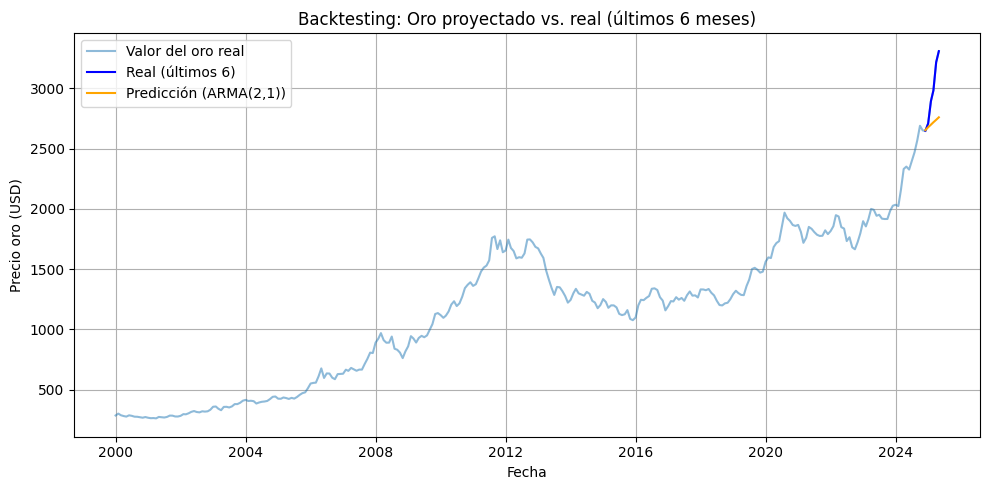

            Oro real  Predicción  Log-retorno predicho
Fecha                                                 
2024-12-01   2648.01     2654.07                  0.00
2025-01-01   2709.69     2678.17                  0.01
2025-02-01   2894.73     2699.22                  0.01
2025-03-01   2983.25     2719.26                  0.01
2025-04-01   3217.64     2739.68                  0.01
2025-05-01   3309.49     2760.32                  0.01


In [ ]:
# Filtrar datos
oro = oro.copy()
log_prices = oro["log_Gold_Price"].dropna()
log_returns = oro["log_diff"].dropna()

# Separar en entrenamiento y prueba (últimos 6 meses)
train = log_returns[:-6]
test = log_returns[-6:]
log_last_value = log_prices.iloc[-7]  # último valor ANTES del test

# Reentrenar ARMA(2,1)
modelo_val = ARIMA(train, order=(2, 0, 1))
resultado_val = modelo_val.fit()

# Predicción de log-retornos
forecast_log_returns = resultado_val.forecast(steps=6)

# Reconstrucción del precio del oro
forecast_log = log_last_value + forecast_log_returns.cumsum()
forecast_price = np.exp(forecast_log)

# Valores reales para comparar
real_price = np.exp(log_prices[-6:])

# Métricas de evaluación
mae = mean_absolute_error(real_price, forecast_price)
rmse = np.sqrt(mean_squared_error(real_price, forecast_price))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# Visualización
plt.figure(figsize=(10,5))
plt.plot(np.exp(log_prices), label="Valor del oro real", alpha=0.5)
plt.plot(real_price.index, real_price.values, label="Real (últimos 6)", color='blue')
plt.plot(real_price.index, forecast_price.values, label="Predicción (ARMA(2,1))", color='orange')
plt.title("Backtesting: Oro proyectado vs. real (últimos 6 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio oro (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabla de predicción vs. realidad
tabla_backtest = pd.DataFrame({
    "Fecha": real_price.index,
    "Oro real": real_price.values,
    "Predicción": forecast_price.values,
    "Log-retorno predicho": forecast_log_returns.values
}).set_index("Fecha")

print(tabla_backtest.round(2))

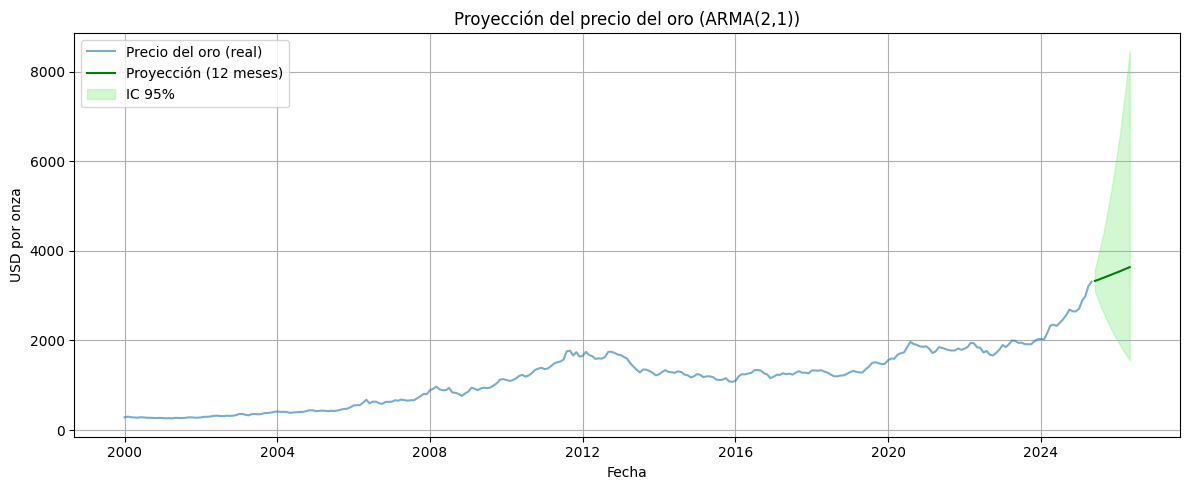

            Predicción  IC 95% Inferior  IC 95% Superior
Fecha                                                   
2025-06-01     3329.59          3106.38          3568.84
2025-07-01     3353.50          2916.16          3856.42
2025-08-01     3381.16          2740.22          4172.03
2025-09-01     3408.76          2574.66          4513.08
2025-10-01     3436.41          2418.99          4881.77
2025-11-01     3464.31          2272.74          5280.61
2025-12-01     3492.44          2135.34          5712.05
2026-01-01     3520.80          2006.24          6178.73
2026-02-01     3549.39          1884.95          6683.54
2026-03-01     3578.21          1770.99          7229.60
2026-04-01     3607.26          1663.92          7820.27
2026-05-01     3636.55          1563.33          8459.20


In [ ]:
# Reentrenar modelo sobre toda la serie de log-retornos
log_returns = oro["log_diff"].dropna()
log_prices = oro["log_Gold_Price"].dropna()
last_log = log_prices.iloc[-1]

modelo_full = ARIMA(log_returns, order=(2, 0, 1))
resultado_full = modelo_full.fit()

# Predecir 12 pasos adelante
n_steps = 12
forecast_result = resultado_full.get_forecast(steps=n_steps)
forecast_log_returns = forecast_result.predicted_mean
forecast_log_returns_ci = forecast_result.conf_int()

# Reconstruir log(Gold_Price)
forecast_log = last_log + forecast_log_returns.cumsum()
ci_lower_log = last_log + forecast_log_returns_ci.iloc[:, 0].cumsum()
ci_upper_log = last_log + forecast_log_returns_ci.iloc[:, 1].cumsum()

# Transformar a escala real
forecast_price = np.exp(forecast_log)
ci_lower = np.exp(ci_lower_log)
ci_upper = np.exp(ci_upper_log)

# Generar fechas futuras
last_date = oro.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Visualización
plt.figure(figsize=(12,5))
plt.plot(oro.index, oro["Gold_Price"], label="Precio del oro (real)", alpha=0.6)
plt.plot(future_dates, forecast_price, label="Proyección (12 meses)", color="green")
plt.fill_between(future_dates, ci_lower, ci_upper, color="lightgreen", alpha=0.4, label="IC 95%")
plt.title("Proyección del precio del oro (ARMA(2,1))")
plt.xlabel("Fecha")
plt.ylabel("USD por onza")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Tabla con predicciones
tabla_forecast = pd.DataFrame({
    "Fecha": future_dates,
    "Predicción": forecast_price.values,
    "IC 95% Inferior": ci_lower.values,
    "IC 95% Superior": ci_upper.values
}).set_index("Fecha")

print(tabla_forecast.round(2))


## Observaciones clave sobre la predicción del precio del oro con ARMA(2,1)

### 1. **Backtesting: comparación entre predicción y datos reales (últimos 6 meses)**

- **Comportamiento general**: El modelo ARMA(2,1) subestima el crecimiento observado en los últimos 6 meses de la serie. La curva de predicción (línea naranja) muestra una pendiente positiva, pero menos pronunciada que la observada en los datos reales (línea azul).
- **Desfase en nivel**: El modelo captura la dirección general del cambio, pero **queda corto en magnitud**, lo que sugiere que el modelo no alcanza a reflejar completamente la aceleración reciente en los precios del oro.
- **Conclusión**: Si bien el modelo muestra coherencia en la tendencia, su capacidad para anticipar movimientos abruptos o no lineales es limitada. Esto indica que el modelo puede requerir una reformulación o la inclusión de efectos exógenos (por ejemplo, indicadores macroeconómicos) para mejorar su capacidad predictiva.

---

### 2. **Proyección a 12 meses con intervalos de confianza**

- **Proyección puntual**: La línea verde representa la predicción puntual del precio del oro para los próximos 12 meses. El modelo proyecta un crecimiento moderado, sin anticipar un cambio de tendencia brusco.
- **Intervalos de confianza**: El área sombreada en verde claro representa el **intervalo de confianza al 95%**, que se ensancha de forma significativa a medida que avanza el horizonte temporal. Esto es característico en modelos ARMA, ya que la incertidumbre se acumula con el paso del tiempo.
- **Interpretación práctica**: Aunque la proyección central parece plausible, la amplitud de los intervalos sugiere **alta incertidumbre** en el pronóstico. El rango de valores proyectados va desde niveles ligeramente inferiores al valor actual hasta valores que duplican o triplican el precio.
- **Conclusión**: El modelo proporciona una visión razonable en el corto plazo (3–4 meses), pero su utilidad decrece más allá de ese horizonte. Para predicciones más robustas, podrían considerarse modelos más complejos o incorporar técnicas como SARIMA o modelos basados en redes neuronales recurrentes.

---

### Recomendación general

El modelo ARMA(2,1) presenta un buen equilibrio en capacidad explicativa. Sin embargo, tanto el backtesting como la proyección a 12 meses indican que su rendimiento es poco aceptable y bastante limitado. Su aplicación se justifica como una línea base estadística, pero no debería utilizarse de forma exclusiva para decisiones críticas sin validación adicional.


# Puede quedar hasta aqui

**De aqui en adelante es un modelo LSTM, no necesariamente lo debemos agregar, pero es interesante para una mejor aproximación que utiliza ML y series de tiempo**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Usamos el precio original, no log-transformado
data = oro["Gold_Price"].values.reshape(-1, 1)

# Normalizar datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Tamaño del set de entrenamiento (80%)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window_size = 60  # número de pasos anteriores usados como entrada
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

# Darle forma (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definir arquitectura
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # salida: un valor

# Compilar modelo
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0339 - val_loss: 0.0101
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0123 - val_loss: 0.0071
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0018 - val_loss: 0.0027


In [ ]:
# Predicción sobre test
predicted_scaled = model.predict(X_test)

# Inversión del escalado
predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


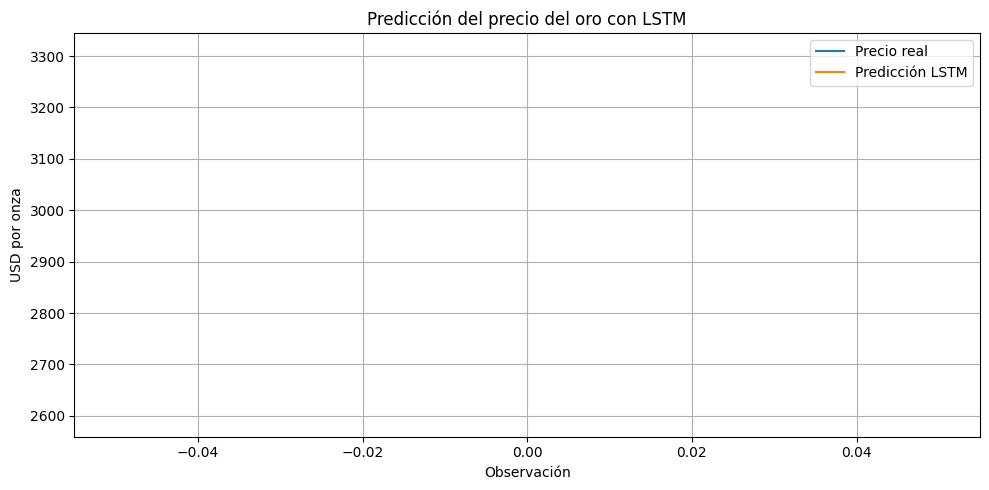

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Precio real")
plt.plot(predicted, label="Predicción LSTM")
plt.title("Predicción del precio del oro con LSTM")
plt.xlabel("Observación")
plt.ylabel("USD por onza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cálculo de métricas
mae = mean_absolute_error(y_test_actual, predicted)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 714.40
RMSE: 714.40


In [ ]:
# Crear DataFrame de comparación
df_comparacion = pd.DataFrame({
    "Fecha": test_index,
    "Precio real (USD)": y_test_actual.flatten(),
    "Predicción LSTM (USD)": predicted.flatten()
})
df_comparacion.set_index("Fecha", inplace=True)

# Mostrar primeras filas
print(df_comparacion.round(2).head(10))


NameError: name 'test_index' is not defined

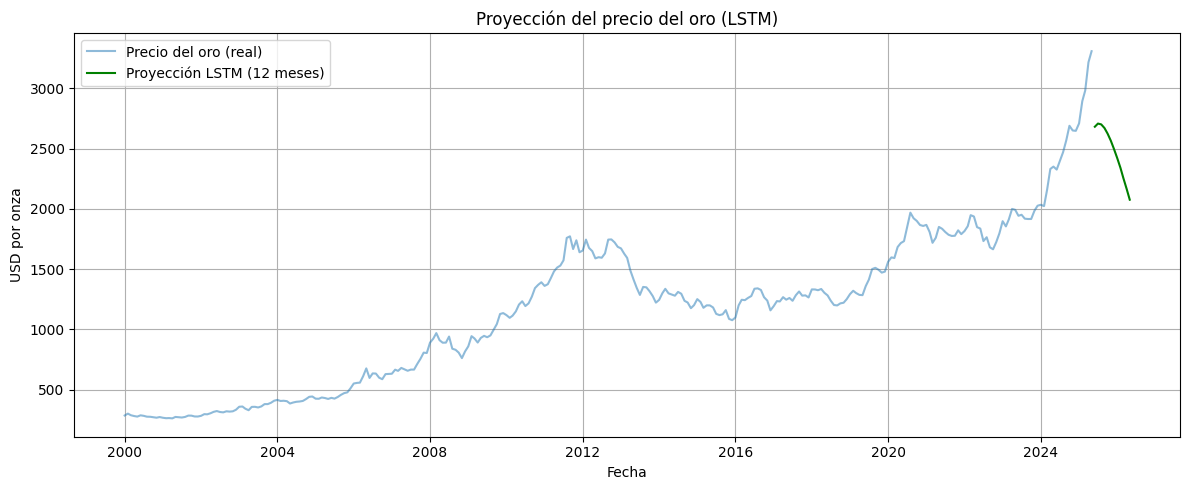

In [ ]:
# Usar la última ventana del set original para iniciar la predicción
last_window = scaled_data[-60:].reshape(1, 60, 1)
future_predictions_scaled = []

# Predecir 12 meses paso a paso
for _ in range(12):
    next_pred = model.predict(last_window, verbose=0)[0][0]
    future_predictions_scaled.append(next_pred)
    # Actualizar la ventana deslizante
    last_window = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)

# Invertir escalado para obtener precios reales
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Crear fechas correspondientes
last_date = oro.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')


# Graficar con la serie real y la proyección a futuro
plt.figure(figsize=(12,5))
plt.plot(oro.index, oro["Gold_Price"], label="Precio del oro (real)", alpha=0.5)
plt.plot(future_dates, future_predictions, label="Proyección LSTM (12 meses)", color='green')
plt.title("Proyección del precio del oro (LSTM)")
plt.xlabel("Fecha")
plt.ylabel("USD por onza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
tabla_futuro = pd.DataFrame({
    "Fecha": future_dates,
    "Predicción LSTM (USD)": future_predictions.flatten()
})
tabla_futuro.set_index("Fecha", inplace=True)
print(tabla_futuro.round(2))

            Predicción LSTM (USD)
Fecha                            
2025-06-01            2682.300049
2025-07-01            2708.510010
2025-08-01            2701.639893
2025-09-01            2671.659912
2025-10-01            2625.040039
2025-11-01            2566.070068
2025-12-01            2497.709961
2026-01-01            2422.110107
2026-02-01            2340.929932
2026-03-01            2255.479980
2026-04-01            2166.909912
2026-05-01            2076.209961
